In [1]:
!tail -2 /local/fever-common/data/fever-data/train.jsonl

tail: cannot open '/local/fever-common/data/fever-data/train.jsonl' for reading: No such file or directory


In [1]:
!tail -2 data/data/fever-data/train.jsonl

{"id": 13114, "verifiable": "VERIFIABLE", "label": "SUPPORTS", "claim": "J. R. R. Tolkien created Gimli.", "evidence": [[[28359, 34669, "Gimli_-LRB-Middle-earth-RRB-", 0]], [[28359, 34670, "Gimli_-LRB-Middle-earth-RRB-", 1]]]}
{"id": 152180, "verifiable": "VERIFIABLE", "label": "SUPPORTS", "claim": "Susan Sarandon is an award winner.", "evidence": [[[176133, 189101, "Susan_Sarandon", 1]], [[176133, 189102, "Susan_Sarandon", 2]], [[176133, 189103, "Susan_Sarandon", 8]]]}


In [13]:
!mkdir -p working/data/training

In [2]:
ls working/data/training/

paper_dev.ns.pages.p5.jsonl  train.ns.pages.p5.jsonl  train.pages.p5.jsonl


In [26]:
!pip install -r requirements.txt

     |████████████████████████████████| 681 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 1.9 MB/s eta 0:00:011
     |████████████████████████████████| 124 kB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 11.0 MB/s eta 0:00:01    |████████████████████▎           | 8.2 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 259 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.1 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 804.1 MB 15 kB/s  eta 0:00:011    |██▍                             | 60.9 MB 10.3 MB/s eta 0:01:13     |██▌                             | 62.5 MB 10.3 MB/s eta 0:01:12     |██▋                             | 64.9 MB 10.3 MB/s eta 0:01:12     |███▏                            | 79.4 MB 6.7 MB/s eta 0:01:48     |███▏                            | 79.8 MB 6.7 MB/s eta 0:01:48     |███▊                            | 

In [2]:

class LabelSchema:
    def __init__(self,labels):
        self.labels = {self.preprocess(val):idx for idx,val in enumerate(labels)}
        self.idx = {idx:self.preprocess(val) for idx,val in enumerate(labels)}

    def get_id(self,label):
        if self.preprocess(label) in self.labels:
            return self.labels[self.preprocess(label)]
        return None

    def preprocess(self,item):
        return item.lower()

class FEVERLabelSchema(LabelSchema):
    def __init__(self):
        super().__init__(["supports", "refutes", "not enough info"])

def nltk_tokenizer(text):
    return " ".join(word_tokenize(text))

class training_line_formatter():
        
    def format(self, lines):
        formatted = []
        for line in tqdm(lines):
            fl = self.format_line(line)
            if fl is not None:
                if isinstance(fl,list):
                    formatted.extend(fl)
                else:
                    formatted.append(fl)
        return formatted

    def format_line(self, line):
        label_schema = FEVERLabelSchema()
        # get the label, i.e. SUPPORTS etc.
        annotation = line["label"]
        if annotation is None:
            annotation = line["verifiable"]
        pages = []
        # did we get the closest sentences to the claim text? is this the sentence or the line number from the doc text?
        if 'predicted_sentences' in line:
            pages.extend([(ev[0], ev[1]) for ev in line["predicted_sentences"]])
        elif 'predicted_pages' in line:
            pages.extend([(ev[0], -1) for ev in line["predicted_pages"]])
        else:
            # these are the human annotated evidence available in the original training file
            for evidence_group in line["evidence"]:
                pages.extend([(ev[2], ev[3]) for ev in evidence_group])
        return {"claim": line["claim"], "evidence": pages, "label": label_schema.get_id(annotation),
                "label_text": annotation}

In [3]:
class Reader:
    def __init__(self,encoding="utf-8"):
        self.enc = encoding

    def read(self,file):
        with open(file,"r",encoding = self.enc) as f:
            return self.process(f)

    def process(self,f):
        pass

class JSONLineReader(Reader):
    def process(self,fp):
        data = []
        for line in tqdm(fp.readlines()):
            data.append(json.loads(line.strip()))
        return data

In [4]:
import json
from tqdm import tqdm
jlr = JSONLineReader()
split = 'train'
working_dir = 'working/data/'
k = 5
training_data_file = working_dir + "training/{0}.ns.pages.p{1}.jsonl".format(split, k)
data = jlr.read(training_data_file)

100%|██████████| 145449/145449 [00:01<00:00, 103300.43it/s]


In [5]:
formatter = training_line_formatter()
formatted_train_data = formatter.format(data)

100%|██████████| 145449/145449 [00:00<00:00, 156929.42it/s]


In [6]:
formatted_train_data[:2]

[{'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [('Nikolaj_Coster-Waldau', 7), ('Fox_Broadcasting_Company', 0)],
  'label': 0,
  'label_text': 'SUPPORTS'},
 {'claim': 'Roman Atwood is a content creator.',
  'evidence': [('Roman_Atwood', 1), ('Roman_Atwood', 3)],
  'label': 0,
  'label_text': 'SUPPORTS'}]

In [7]:
[d for d in formatted_train_data if d['label_text'] == 'NOT ENOUGH INFO'][:5]

[{'claim': 'System of a Down briefly disbanded in limbo.',
  'evidence': [('In_Limbo', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Beautiful reached number two on the Billboard Hot 100 in 2003.',
  'evidence': [('Ricky_Martin_singles_discography', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Neal Schon was named in 1954.',
  'evidence': [('Double_Eclipse', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'John Wick: Chapter 2 was theatrically released in the Oregon.',
  'evidence': [('John_Wick_-LRB-disambiguation-RRB-', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Afghanistan is the source of the Kushan dynasty.',
  'evidence': [('Kanishka_-LRB-name-RRB-', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'}]

#### RANDOMS, NEARESTP approach
TODO: Need to sample sentences for the 'not enough info' class, either sample them randomly from the nearest matching document, or sample random sentences from the Wiki corpus.

In [8]:
import json
from tqdm import tqdm
jlr = JSONLineReader()
split = 'paper_dev'
working_dir = 'working/data/'
k = 5
dev_data_file = working_dir + "training/{0}.ns.pages.p{1}.jsonl".format(split, k)
dev_data = jlr.read(dev_data_file)

formatter = training_line_formatter()
formatted_dev_data = formatter.format(dev_data)

dev_data_formatted = []
dev_data_formatted.extend(filter(lambda record: record is not None, formatted_dev_data))
dev_data_formatted[:2]

100%|██████████| 9999/9999 [00:00<00:00, 199669.81it/s]


[{'claim': 'Colin Kaepernick became a starting quarterback during the 49ers 63rd season in the National Football League.',
  'evidence': [('Colin_Kaepernick', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Tilda Swinton is a vegan.',
  'evidence': [('Swinton_-LRB-surname-RRB-', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'}]

#### Build the tokenizer

In [9]:
import random
import os

class SimpleRandom():
    instance = None

    def __init__(self,seed):
        self.seed = seed
        self.random = random.Random(seed)

    def next_rand(self,a,b):
        return self.random.randint(a,b)

    @staticmethod
    def get_instance():
        if SimpleRandom.instance is None:
            SimpleRandom.instance = SimpleRandom(SimpleRandom.get_seed())
        return SimpleRandom.instance

    @staticmethod
    def get_seed():
        return int(os.getenv("RANDOM_SEED", 12459))

    @staticmethod
    def set_seeds():

        torch.manual_seed(SimpleRandom.get_seed())
        if gpu():
            torch.cuda.manual_seed_all(SimpleRandom.get_seed())
        np.random.seed(SimpleRandom.get_seed())
        random.seed(SimpleRandom.get_seed())

In [10]:
from drqa.retriever import DocDB, utils
class FeverDocDB(DocDB):

    def __init__(self,path=None):
        super().__init__(path)

    def get_doc_lines(self, doc_id):
        """Fetch the raw text of the doc for 'doc_id'."""
        cursor = self.connection.cursor()
        cursor.execute(
            "SELECT lines FROM documents WHERE id = ?",
            (utils.normalize(doc_id),)
        )
        result = cursor.fetchone()
        cursor.close()
        return result if result is None else result[0]

    def get_non_empty_doc_ids(self):
        """Fetch all ids of docs stored in the db."""
        cursor = self.connection.cursor()
        cursor.execute("SELECT id FROM documents WHERE length(trim(text)) > 0")
        results = [r[0] for r in cursor.fetchall()]
        cursor.close()
        return results
#database_path = '/local/fever-common/data/fever/fever.db'
database_path = 'data/data/fever/fever.db'
database = FeverDocDB(database_path)

In [11]:
ename = "evidence"
def claims(data):
    return [datum["claim"] for datum in data]
def body_ids(data):
    return [[d[0] for d in datum[ename] ] for datum in data]
def flatten(l):
    return [item for sublist in l for item in sublist]
def bodies(data):
    return [database.get_doc_text(id) for id in set(flatten(body_ids(data)))]

def texts(data):
    return [" ".join(set(instance)) for instance in body_lines(data)]

def body_lines(data):
    return [[get_doc_line(d[0],d[1]) for d in datum[ename] ] for datum in data]

def get_doc_line(doc,line):
    lines = database.get_doc_lines(doc)
    ### if this is from annotated evidences
    if line > -1:
        return lines.split("\n")[line].split("\t")[1] #get all the lines from the document and match with the line ids that were annotated as evidence by the human annotators
    else: ### if this is from not enough info evidences, NearestP method, to sample "a" single sentence randomly from the nearest page match
        non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
        return non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]    

In [12]:
[d for d in formatted_train_data if d['label_text'] == 'NOT ENOUGH INFO'][:2]

[{'claim': 'System of a Down briefly disbanded in limbo.',
  'evidence': [('In_Limbo', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'},
 {'claim': 'Beautiful reached number two on the Billboard Hot 100 in 2003.',
  'evidence': [('Ricky_Martin_singles_discography', -1)],
  'label': 2,
  'label_text': 'NOT ENOUGH INFO'}]

In [14]:
cl = formatted_train_data[0]['claim']
ev = formatted_train_data[0]['evidence']
[(d[0],d[1]) for d in ev]

[('Nikolaj_Coster-Waldau', 7), ('Fox_Broadcasting_Company', 0)]

In [15]:
get_doc_line('Nikolaj_Coster-Waldau', 7)

'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .'

In [16]:
lines = database.get_doc_lines('Ricky_Martin_singles_discography')
lines

"0\tPuerto Rican singer Ricky Martin has released seventy-nine Spanish and English-language singles .\tRicky Martin\tRicky Martin (1999 album)\tsingles\tsingle (music)\n1\tIn 1984 , thirteen-year-old Martin became a member of the Puerto Rican boy band Menudo .\tMenudo\tMenudo (band)\n2\tAfter recording eleven albums with the group , he left Menudo in 1989 , hoping to rest and evaluate his career path .\tMenudo\tMenudo (band)\n3\tIn 1990 , he was signed to Sony Discos , the Sony Music Entertainment 's Latin imprint .\tSony Discos\tSony Music Latin\tSony Music Entertainment\tSony Music Entertainment\n4\tMartin released his debut solo album , the Spanish-language Ricky Martin , in November 1991 .\tRicky Martin\tRicky Martin (1999 album)\n5\tIt included hit singles : `` Fuego Contra Fuego '' , `` El Amor de Mi Vida '' and `` Vuelo '' .\tsingles\tsingle (music)\tFuego Contra Fuego\tFuego Contra Fuego\tEl Amor de Mi Vida\tEl Amor de Mi Vida (song)\tVuelo\tVuelo (song)\tVida\tVida (Ricky Mart

In [17]:
non_empty_lines = [line.split("\t")[1] for line in lines.split("\n") if len(line.split("\t"))>1 and len(line.split("\t")[1].strip())]
len(non_empty_lines)

76

In [18]:
non_empty_lines[SimpleRandom.get_instance().next_rand(0,len(non_empty_lines)-1)]

'It was also certified five-times Platinum in Spain and four-times Platinum in Mexico .'

In [19]:
[get_doc_line(d[0],d[1]) for d in formatted_train_data[0]["evidence"] ]

['He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .',
 'The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .']

In [13]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '[START] ' + w + ' [END]'
        return w

In [21]:
for data in formatted_train_data[:2]:
    claim = preprocess(data["claim"])
    lines = [get_doc_line(d[0],d[1]) for d in data["evidence"] ]
#     body_ids = [e[0] for e in data["evidence"]]
#     bodies = [database.get_doc_text(id) for id in set(body_ids)]
#     parts = [claim, " ".join(bodies)]
    parts = [claim, " ".join(lines)]
    print (" ".join(parts))

[START] nikolaj coster waldau worked with the fox broadcasting company . [END] He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .
[START] roman atwood is a content creator . [END] He is best known for his vlogs , where he posts updates about his life on a daily basis . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .


In [14]:
import numpy as np
import tensorflow as tf
def get_data_generator():
    for data in formatted_train_data:
        claim = preprocess(data["claim"])
        body_ids = [e[0] for e in data["evidence"]]
        bodies = [database.get_doc_text(id) for id in set(body_ids)]
        parts = [claim, " ".join(bodies)]
        yield " ".join(parts)
        
def get_dataset():
    generator = lambda: get_data_generator()
    return tf.data.Dataset.from_generator(
            generator, output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string)))

In [15]:
for d in get_dataset().take(1):
    print(d)

tf.Tensor(b"[START] nikolaj coster waldau worked with the fox broadcasting company . [END] Nikolaj Coster-Waldau -LRB- -LSB- ne\xc9\xa1\xcc\x8aola\xc9\xaa\xcc\xaf k\xca\xb0\xca\x8csd\xcc\xa5\xc9\x90 \xcb\x88\xca\x8bald\xcc\xa5\xc9\x91\xca\x8a\xcc\xaf -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter . He graduated from Danish National School of Theatre in Copenhagen in 1993 . Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- . Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .   In the United States , his debut film role was in the war film Black Hawk Down -LRB- 2001 -RRB- , playing Medal of Honor recipient Gary Gordon . He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in t

In [25]:
ds = get_dataset()
batch_size=32
ds = ds.shuffle(3200).batch(batch_size, drop_remainder=True)

In [26]:
for d in ds.take(1):
    print(d)

tf.Tensor(
[b"[START] u released the album how to dismantle an atomic bomb in . [END] U2 are an Irish rock band from Dublin formed in 1976 . The group consists of Bono -LRB- lead vocals and rhythm guitar -RRB- , the Edge -LRB- lead guitar , keyboards , and backing vocals -RRB- , Adam Clayton -LRB- bass guitar -RRB- , and Larry Mullen Jr. -LRB- drums and percussion -RRB- . Initially rooted in post-punk , U2 's sound grew to incorporate influences from many genres of popular music , yet has maintained an anthemic sound built on Bono 's expressive vocals and the Edge 's effects-based guitar textures . Their lyrics , often embellished with spiritual imagery , focus on personal themes and sociopolitical concerns . Popular for their live performances , the group have staged several ambitious and elaborate tours over their career .   The band formed at Mount Temple Comprehensive School in 1976 when the members were teenagers with limited musical proficiency . Within four years , they signed w

In [15]:
#pip install tensorflow_text

     |████████████████████████████████| 4.3 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 454.4 MB 79 kB/s  eta 0:00:011   |█                               | 14.9 MB 4.8 MB/s eta 0:01:31     |██▎                             | 32.7 MB 6.6 MB/s eta 0:01:04     |████▍                           | 63.0 MB 2.5 MB/s eta 0:02:34     |█████████▏                      | 130.5 MB 12.6 MB/s eta 0:00:26     |█████████▎                      | 131.2 MB 12.6 MB/s eta 0:00:26     |█████████████████████▏          | 301.3 MB 911 kB/s eta 0:02:49     |█████████████████████▉          | 309.9 MB 10.4 MB/s eta 0:00:14     |█████████████████████████▉      | 367.6 MB 4.4 MB/s eta 0:00:20     |██████████████████████████▏     | 372.1 MB 11.0 MB/s eta 0:00:08
     |████████████████████████████████| 108 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 3.1 MB/s eta 0:00:01
     |██████████████████████████████

In [16]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [17]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [60]:
%%time
pt_vocab = bert_vocab.bert_vocab_from_dataset(
    ds.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 11min 3s, sys: 37.1 s, total: 11min 40s
Wall time: 10min 52s


In [61]:
print(pt_vocab[:10])
print(pt_vocab[100:110])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '$', '%', '&']
['ɕ', 'ɖ', 'ə', 'ɚ', 'ɛ', 'ɜ', 'ɝ', 'ɟ', 'ɡ', 'ɣ']


In [62]:
def write_vocab_file(filepath, vocab):
    print("Saving vocab file to {}".format(filepath))
    with open(filepath, 'w') as f:
        for token in vocab:
            print(token, file=f)

In [63]:
vocab_file_out = 'working/data/fever_vocab.txt'
write_vocab_file(vocab_file_out, pt_vocab)

Saving vocab file to working/data/fever_vocab.txt


In [64]:
print(len(pt_vocab))

7860


In [4]:
!wc -l working/data/fever_vocab.txt

7860 working/data/fever_vocab.txt


In [60]:
!head -10 working/data/fever_vocab.txt

[PAD]
[UNK]
[START]
[END]
!
"
#
$
%
&


#### Load the vocab and initialize the tokenizer

In [18]:
import tensorflow_text as text
bert_tokenizer_params=dict(lower_case=True)
vocab_file_out = 'working/data/fever_vocab.txt'
pt_tokenizer = text.BertTokenizer(vocab_file_out, **bert_tokenizer_params)

In [19]:
for d in get_dataset().take(1):
    print(d)

tf.Tensor(b"[START] nikolaj coster waldau worked with the fox broadcasting company . [END] Nikolaj Coster-Waldau -LRB- -LSB- ne\xc9\xa1\xcc\x8aola\xc9\xaa\xcc\xaf k\xca\xb0\xca\x8csd\xcc\xa5\xc9\x90 \xcb\x88\xca\x8bald\xcc\xa5\xc9\x91\xca\x8a\xcc\xaf -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter . He graduated from Danish National School of Theatre in Copenhagen in 1993 . Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- . Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .   In the United States , his debut film role was in the war film Black Hawk Down -LRB- 2001 -RRB- , playing Medal of Honor recipient Gary Gordon . He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in t

In [20]:
from sklearn import preprocessing

labels = [d['label_text'] for d in formatted_train_data]
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_enc = le.transform(labels)

In [21]:
train_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    train_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(train_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(train_labels)))

A peek a the reshaped labels:
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [22]:
lbls = tf.reshape(tf.convert_to_tensor(train_labels, dtype=tf.int32), (train_labels.shape))
lbls_ds = tf.data.Dataset.from_tensor_slices(lbls)
lbls_ds

<TensorSliceDataset shapes: (3,), types: tf.int32>

In [23]:
import numpy as np
import tensorflow as tf
def get_train_data_generator():
    for data in formatted_train_data:
        claim = preprocess(data["claim"])
#         body_ids = [e[0] for e in data["evidence"]]
#         bodies = [database.get_doc_text(id) for id in set(body_ids)]
        lines = [get_doc_line(d[0],d[1]) for d in data["evidence"]]
        yield claim, " ".join(lines)
        
def get_train_dataset():
    generator = lambda: get_train_data_generator()
    return tf.data.Dataset.from_generator(
            generator, output_signature=(
            tf.TensorSpec(shape=(2, ), dtype=tf.string)))

In [24]:
raw_ds = get_train_dataset()

In [36]:
for d,e in raw_ds.take(1):
    print(e)
    print(".....\n\n")
    print(d)

tf.Tensor(b'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .', shape=(), dtype=string)
.....


tf.Tensor(b'[START] nikolaj coster waldau worked with the fox broadcasting company . [END]', shape=(), dtype=string)


In [25]:
raw_ds_enc_labls = tf.data.Dataset.zip((raw_ds, lbls_ds))
print(raw_ds_enc_labls.element_spec)

(TensorSpec(shape=(2,), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))


#### Dev dataset

In [26]:
import numpy as np
import tensorflow as tf
def get_dev_data_generator():
    for data in dev_data_formatted:
        claim = preprocess(data["claim"])
#         body_ids = [e[0] for e in data["evidence"]]
#         bodies = [database.get_doc_text(id) for id in set(body_ids)]
        lines = [get_doc_line(d[0],d[1]) for d in data["evidence"]]
        yield claim, " ".join(lines)
        
def get_dev_dataset():
    generator = lambda: get_dev_data_generator()
    return tf.data.Dataset.from_generator(
            generator, output_signature=(
            tf.TensorSpec(shape=(2, ), dtype=tf.string)))

In [27]:
dev_ds = get_dev_dataset()

In [28]:
labels = [d['label_text'] for d in dev_data_formatted]
labels_enc = le.transform(labels)

In [29]:
dev_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    dev_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(dev_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(dev_labels)))

A peek a the reshaped labels:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [30]:
lbls = tf.reshape(tf.convert_to_tensor(dev_labels, dtype=tf.int32), (dev_labels.shape))
print(lbls)
dev_lbls_ds = tf.data.Dataset.from_tensor_slices(lbls)
dev_lbls_ds

tf.Tensor(
[[1 0 0]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]], shape=(9999, 3), dtype=int32)


<TensorSliceDataset shapes: (3,), types: tf.int32>

In [31]:
dev_ds_enc_labls = tf.data.Dataset.zip((dev_ds, dev_lbls_ds))
print(dev_ds_enc_labls.element_spec)

(TensorSpec(shape=(2,), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))


#### Build the sequences

In [45]:
for d, e in raw_ds_enc_labls.take(1):
    print(d[0])
    print("........\n\n")
    print(d[1])
    print("........\n\n")
    print(e)

tf.Tensor(b'[START] nikolaj coster waldau worked with the fox broadcasting company . [END]', shape=(), dtype=string)
........


tf.Tensor(b'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .', shape=(), dtype=string)
........


tf.Tensor([0 0 1], shape=(3,), dtype=int32)


In [32]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = raw_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[0], MAX_SEQ_LEN))
e = raw_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
l = raw_ds_enc_labls.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
dataset = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
print(dataset.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


In [33]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = dev_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[0], MAX_SEQ_LEN))
e = dev_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
l = dev_ds_enc_labls.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
dataset_dev = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset_dev)
print(dataset_dev.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


#### Prepare the glove embeddings

In [63]:
import zipfile, io
glove_zip_file = "entailment/data/glove.6B.zip"
glove_vectors_file = "glove.6B.100d.txt"
embeddings_index = {}
with zipfile.ZipFile(glove_zip_file) as z:
        for info in z.infolist():
            print(info.filename)
            if glove_vectors_file in info.filename:
                # read the file
                print("Reading lines from file {}".format(glove_vectors_file))
                with io.TextIOWrapper(z.open(glove_vectors_file), encoding="utf-8") as f:
                    for line in f:
                        terms = line.split()
                        word = terms[0]
                        coefs = np.asarray(terms[1:], dtype='float32')
                        
                        embeddings_index[word] = coefs

glove.6B.50d.txt
glove.6B.100d.txt
Reading lines from file glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt


In [65]:
embeddings_index["the"].shape
max_length = embeddings_index["the"].shape[0]
print("max length of sequence is {}".format(max_length))
print(embeddings_index["the"])

max length of sequence is 100
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028 

In [124]:
embeddings_index['start'].shape[0]

100

In [167]:
for d in ds.batch(1):
    print(d.shape)
    break

(1, 32)


In [177]:
for d in ds.batch(1):
    print(d.shape)
    emb = pt_tokenizer.tokenize(d[0])
    embd = pt_tokenizer.detokenize(emb)
    break

(1, 32)


In [192]:
print(emb.shape)

(32, None, None)


In [191]:
print(embd.shape)

(32, None, None)


In [250]:
word_batch = [[w[0].decode() for w in w_np] for w_np in [word.numpy() for word in embd]]
index_batch = [[w[0] for w in w_np] for w_np in [word.numpy() for word in emb]]

In [258]:
index_batch[0]

[36,
 1035,
 38,
 57,
 1872,
 1007,
 5726,
 1212,
 17,
 36,
 1026,
 38,
 57,
 1807,
 1054,
 57,
 2049,
 1004,
 1373,
 1673,
 15,
 4408,
 15,
 1002,
 1082,
 1659,
 16,
 3213,
 5537,
 1003,
 4725,
 15,
 2309,
 5668,
 1590,
 1475,
 1214,
 1009,
 2049,
 1007,
 6674,
 2891,
 5522,
 3470,
 1061,
 3213,
 3242,
 17,
 42,
 57,
 57,
 1009,
 1719,
 1020,
 49,
 4157,
 1129,
 1012,
 1756,
 5070,
 1002,
 1756,
 3385,
 17,
 5459,
 57,
 57,
 15,
 1475,
 49,
 4157,
 1054,
 1159,
 1014,
 6502,
 56,
 1002,
 6041,
 5299,
 1782,
 1219,
 1001,
 3213,
 5131,
 17,
 1001,
 1051,
 1971,
 57,
 1079,
 1289,
 1748,
 1033,
 1872,
 1007,
 4786,
 15,
 5726,
 1212,
 15,
 3154,
 3889,
 6283,
 15,
 57,
 6525,
 1061,
 5726,
 1872,
 15,
 1002,
 44,
 17]

In [259]:
word_batch[0]

['[',
 'start',
 ']',
 'paranormal',
 'pertains',
 'to',
 'extraterrestrial',
 'life',
 '.',
 '[',
 'end',
 ']',
 'paranormal',
 'events',
 'are',
 'phenomena',
 'described',
 'in',
 'popular',
 'culture',
 ',',
 'folklore',
 ',',
 'and',
 'other',
 'non',
 '-',
 'scientific',
 'bodies',
 'of',
 'knowledge',
 ',',
 'whose',
 'existence',
 'within',
 'these',
 'contexts',
 'is',
 'described',
 'to',
 'lie',
 'beyond',
 'normal',
 'experience',
 'or',
 'scientific',
 'explanation',
 '.',
 'a',
 'paranormal',
 'phenomenon',
 'is',
 'different',
 'from',
 'hypothetical',
 'concepts',
 'such',
 'as',
 'dark',
 'matter',
 'and',
 'dark',
 'energy',
 '.',
 'unlike',
 'paranormal',
 'phenomena',
 ',',
 'these',
 'hypothetical',
 'concepts',
 'are',
 'based',
 'on',
 'empirical',
 'observations',
 'and',
 'experimental',
 'data',
 'gained',
 'through',
 'the',
 'scientific',
 'method',
 '.',
 'the',
 'most',
 'notable',
 'paranormal',
 'beliefs',
 'include',
 'those',
 'that',
 'pertain',
 'to'

In [ ]:
max_length = embeddings_index['start'].shape[0]
vocab_size = 8000
embedding_matrix = np.zeros((vocab_size + 1, max_length))

In [264]:
# d is already a batch of 32 examples
for d in ds.batch(1):
    emb = pt_tokenizer.tokenize(d[0])
    embd = pt_tokenizer.detokenize(emb)
    word_batch = [[w[0].decode() for w in w_np] for w_np in [word.numpy() for word in embd]]
    index_batch = [[w[0] for w in w_np] for w_np in [word.numpy() for word in emb]]
    for w_batch, i_batch in zip(word_batch, index_batch):
        for w, i in zip(w_batch, i_batch):
            embedding_vector = embeddings_index.get(w)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

In [265]:
# embedding_file = "working/data/embedding_mappings.npz"
# np.savez(embedding_file, embedding_matrix)

In [34]:
npzfile = np.load("working/data/embedding_mappings.npz")
npzfile.files

['arr_0']

In [35]:
embedding_matrix = npzfile['arr_0']

In [36]:
embedding_matrix.shape

(8001, 100)

In [37]:
!ls -lth working/data/

total 51M
-rw-rw-r-- 1 ubuntu ubuntu 6.2M Jul 16 15:27 embedding_mappings.npz
drwxrwxr-x 2 ubuntu ubuntu 4.0K Jul 16 11:11 training
-rw-r--r-- 1 ubuntu ubuntu  39M Jul 16 11:09 train_x.npz
-rw-r--r-- 1 ubuntu ubuntu 2.3M Jul 16 11:09 dev_x.npz
-rw-r--r-- 1 ubuntu ubuntu 235K Jul 16 11:08 dev_labels.npz
-rw-r--r-- 1 ubuntu ubuntu 3.4M Jul 16 11:08 train_labels.npz
-rw-r--r-- 1 ubuntu ubuntu  50K Jul 16 11:08 fever_vocab.txt


In [39]:
from tensorflow import keras
import tensorflow as tf
from keras.regularizers import l2

In [40]:
### Simple model
vocab_size= 8000
dim = 100
inp1 = keras.Input(shape=(None, ), name = "hypothesis")
inp2 = keras.Input(shape=(None, ), name = "evidence")
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
embedding_evi_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
x_hyp = embedding_hyp_layer(inp1)
x_evi = embedding_evi_layer(inp2)
lstm_layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_hyp)
lstm_layer2 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_evi)
w = keras.layers.concatenate([lstm_layer1, lstm_layer2], axis = 1)
x1 = tf.keras.layers.Dense(16, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(w)
x2 = tf.keras.layers.Dropout(0.3)(x1)
output = tf.keras.layers.Dense(3, activation='softmax')(x2)
model = keras.Model(inputs=[inp1, inp2], outputs=output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hypothesis (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
evidence (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    800100      hypothesis[0][0]                 
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    800100      evidence[0][0]                   
______________________________________________________________________________________________

In [41]:
rm -rf tmp/checkpoint_*

In [42]:
checkpoint_filepath = 'tmp/checkpoint_fever_nli'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [43]:
history = model.fit(dataset, epochs = 12, validation_data=dataset_dev, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/12
2272/2272 [==============================] - 538s 211ms/step - loss: 0.7664 - accuracy: 0.6910 - val_loss: 0.8617 - val_accuracy: 0.6031
Epoch 2/12
2272/2272 [==============================] - 516s 207ms/step - loss: 0.6421 - accuracy: 0.7492 - val_loss: 0.8119 - val_accuracy: 0.6360
Epoch 3/12
2272/2272 [==============================] - 518s 208ms/step - loss: 0.5918 - accuracy: 0.7729 - val_loss: 0.8743 - val_accuracy: 0.6314
Epoch 4/12
2272/2272 [==============================] - 517s 207ms/step - loss: 0.5528 - accuracy: 0.7907 - val_loss: 0.8438 - val_accuracy: 0.6529
Epoch 5/12
2272/2272 [==============================] - 518s 208ms/step - loss: 0.5218 - accuracy: 0.8060 - val_loss: 0.8887 - val_accuracy: 0.6418
Epoch 6/12
2272/2272 [==============================] - 517s 207ms/step - loss: 0.4960 - accuracy: 0.8169 - val_loss: 0.9383 - val_accuracy: 0.6361
Epoch 7/12
2272/2272 [==============================] - 516s 207ms/step - loss: 0.4745 - accuracy: 0.8254 - val_

##### TODO: use DA 
https://gist.github.com/namakemono/f4f273dbc63fc2174940415a9f689a6f

In [44]:
model.load_weights(checkpoint_filepath)
model.evaluate(dataset_dev)

156/156 [==============================] - 22s 41ms/step - loss: 0.9469 - accuracy: 0.6569


[0.9468783140182495, 0.6568509340286255]

Text(0.5, 1.0, 'Metrics for training SNLI dataset, 70K samples (glove 100d)')

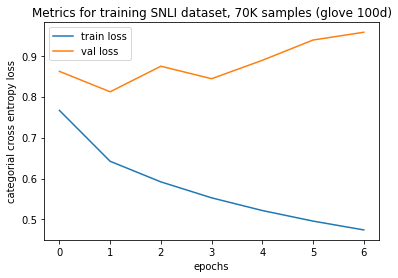

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training SNLI dataset, 70K samples (glove 100d)")
#history.history['loss']

#### Model using attention
See example here https://keras.io/api/layers/attention_layers/attention/

In [59]:
# Variable-length int sequences.
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
# cnn_layer = tf.keras.layers.Conv1D(
#     filters=100,
#     kernel_size=4,
#     # Use 'same' padding so outputs have the same shape as inputs.
#     padding='same')
# Query encoding of shape [batch_size, Tq, filters].
# query_seq_encoding = cnn_layer(query_embeddings)
# # Value encoding of shape [batch_size, Tv, filters].
# value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
# query_value_attention_seq = tf.keras.layers.Attention()(
#     [query_seq_encoding, value_seq_encoding])

query_value_attention_seq = tf.keras.layers.Attention()(
    [query_embeddings, value_embeddings])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_embeddings)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])

# input_layer = tf.keras.layers.Concatenate()(
#     [query_embeddings, query_value_attention_seq])

x1 = tf.keras.layers.Dense(16, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(input_layer)
x2 = tf.keras.layers.Dropout(0.3)(x1)
output = tf.keras.layers.Dense(3, activation='softmax')(x2)
model = keras.Model(inputs=[query_input, value_input], outputs=output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 100)    800100      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
attention_6 (Attention)         (None, None, 100)    0           embedding_8[0][0]          

In [50]:
!mkdir -p tmp/attention/

In [60]:
checkpoint_filepath = 'tmp/attention/checkpoint_fever_rte'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [61]:
history = model.fit(dataset, epochs = 12, validation_data=dataset_dev, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/12
2272/2272 [==============================] - 238s 84ms/step - loss: 0.9525 - accuracy: 0.5943 - val_loss: 1.1095 - val_accuracy: 0.4238
Epoch 2/12
2272/2272 [==============================] - 237s 84ms/step - loss: 0.9127 - accuracy: 0.6083 - val_loss: 1.0772 - val_accuracy: 0.4508
Epoch 3/12
2272/2272 [==============================] - 236s 83ms/step - loss: 0.9025 - accuracy: 0.6120 - val_loss: 1.0692 - val_accuracy: 0.4495
Epoch 4/12
2272/2272 [==============================] - 236s 83ms/step - loss: 0.8955 - accuracy: 0.6156 - val_loss: 1.0526 - val_accuracy: 0.4726
Epoch 5/12
2272/2272 [==============================] - 235s 83ms/step - loss: 0.8906 - accuracy: 0.6188 - val_loss: 1.0667 - val_accuracy: 0.4575
Epoch 6/12
2272/2272 [==============================] - 238s 84ms/step - loss: 0.8859 - accuracy: 0.6219 - val_loss: 1.0521 - val_accuracy: 0.4606
Epoch 7/12
2272/2272 [==============================] - 238s 84ms/step - loss: 0.8844 - accuracy: 0.6221 - val_loss: 1

In [53]:
!pip list | grep tensorflow

tensorflow                         2.5.0
tensorflow-datasets                4.3.0
tensorflow-estimator               2.5.0
tensorflow-gpu                     2.5.0
tensorflow-hub                     0.12.0
tensorflow-metadata                1.1.0
tensorflow-serving-api             2.4.1
tensorflow-text                    2.5.0
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.


In [54]:
!pip list | grep cudn

You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.
